In [2]:
import json

import nibabel as nib
import os

In [3]:
data_folder = "/home/yeep/dataset/3d/SPH"
img_folder, mask_folder = data_folder + "/imagesTr", data_folder + "/labelsTr"
img_names = os.listdir(img_folder)

In [4]:
mindim0, mindim1, mindim2 = float("inf"), float("inf"), float("inf")
maxdim0, maxdim1, maxdim2 = -1, -1, -1
slices = []
for name in img_names:
    img = nib.load(img_folder + "/" + name).get_fdata()
    mindim0 = min(img.shape[0], mindim0)
    mindim1 = min(img.shape[1], mindim1)
    mindim2 = min(img.shape[2], mindim2)
    slices.append(img.shape[2])
    maxdim0 = max(img.shape[0], maxdim0)
    maxdim1 = max(img.shape[1], maxdim1)
    maxdim2 = max(img.shape[2], maxdim2)

KeyboardInterrupt: 

In [101]:
mindim0, mindim1, mindim2

(256, 256, 25)

In [102]:
maxdim0, maxdim1, maxdim2

(640, 640, 80)

In [103]:
import numpy as np
import matplotlib.pyplot as plt

(array([  4., 109.,  51.,  29.,   3.,   1.,   0.,   9.,   0.,   2.]),
 array([25. , 30.5, 36. , 41.5, 47. , 52.5, 58. , 63.5, 69. , 74.5, 80. ]),
 <BarContainer object of 10 artists>)

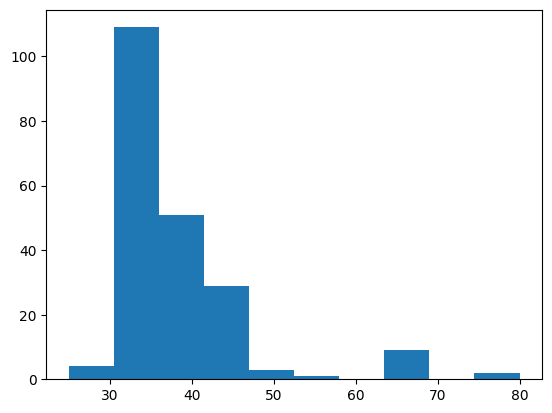

In [104]:
plt.hist(slices)

In [105]:
pixel_mask = []
for name in os.listdir(mask_folder):
    mask = nib.load(mask_folder + "/" + name).get_fdata()
    for idx in range(mask.shape[-1]):
        mask[mask >= 1] = 1
        pixel = mask[:, :, idx].sum()
        pixel_mask.append(pixel / mask.shape[0] / mask.shape[1])

In [106]:
a = np.array(sorted(pixel_mask))

In [107]:
a.size, np.count_nonzero(a), a.size - np.count_nonzero(a)

(8145, 1833, 6312)

(array([756., 558., 295., 125.,  52.,  24.,  15.,   5.,   0.,   3.]),
 array([2.44140625e-06, 8.72949219e-03, 1.74565430e-02, 2.61835937e-02,
        3.49106445e-02, 4.36376953e-02, 5.23647461e-02, 6.10917969e-02,
        6.98188477e-02, 7.85458984e-02, 8.72729492e-02]),
 <BarContainer object of 10 artists>)

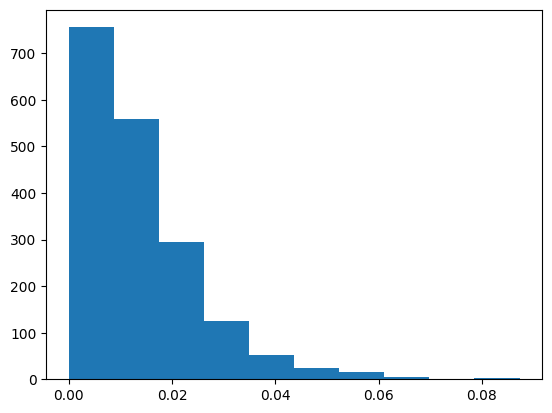

In [109]:
plt.hist(a[6312:])

# 预处理

In [170]:
import SimpleITK as sitk
import random

In [171]:
slice_per_volume = 10

In [35]:
class MedicalImageDeal(object):
    def __init__(self, img, percent=1):
        self.img = img
        self.percent = percent

    @property
    def valid_img(self):
        from skimage import exposure
        cdf = exposure.cumulative_distribution(self.img)
        watershed = cdf[1][cdf[0] >= self.percent][0]
        return np.clip(self.img, self.img.min(), watershed)

    def norm_img(self, img):
        return (img - img.min()) / (img.max() - img.min())

In [173]:
def rand_uniform_select(axial_len, select=25):
    assert axial_len >= select
    slices = np.arange(select)
    uniform_sample = np.unique(np.random.uniform(0, axial_len, size=select).astype(np.uint8))
    xorld = np.setdiff1d(slices, uniform_sample)
    random_sampler = np.random.choice(xorld, select - len(uniform_sample), replace=False)
    return sorted([*uniform_sample, *random_sampler])

In [174]:
import json
import SimpleITK as sitk
import cv2

with open(f"{data_folder}/data.json") as fp:
    jsondes = json.load(fp)

In [175]:
file_names = jsondes["train"]
file_names

[{'image': 'imagesTr/MR1201810170136__t1_fs_tse_rs_tra_0_0_0_axial_20181019.nii.gz',
  'label': 'labelsTr/MR1201810170136__t1_fs_tse_rs_tra_0_0_0_axial_20181019.nii.gz'},
 {'image': 'imagesTr/MR1201708280262__t1_fs_tse_rs_tra_0_0_0_axial_20170830.nii.gz',
  'label': 'labelsTr/MR1201708280262__t1_fs_tse_rs_tra_0_0_0_axial_20170830.nii.gz'},
 {'image': 'imagesTr/MR1201611180212__T1W_TSE_SPIR+C_0_0_0_axial_20161121.nii.gz',
  'label': 'labelsTr/MR1201611180212__T1W_TSE_SPIR+C_0_0_0_axial_20161121.nii.gz'},
 {'image': 'imagesTr/MR1201707200224__t1_fs_tse_rs_tra_0_0_1_axial_20170724.nii.gz',
  'label': 'labelsTr/MR1201707200224__t1_fs_tse_rs_tra_0_0_1_axial_20170724.nii.gz'},
 {'image': 'imagesTr/MR1202001210130__t1_fs_tse_rs_tra_0_0_0_axial_20200122.nii.gz',
  'label': 'labelsTr/MR1202001210130__t1_fs_tse_rs_tra_0_0_0_axial_20200122.nii.gz'},
 {'image': 'imagesTr/MR1201804110166__t1_fs_tse_rs_tra_0_0_0_axial_20180416.nii.gz',
  'label': 'labelsTr/MR1201804110166__t1_fs_tse_rs_tra_0_0_0_axi

In [176]:
for name in file_names:
    image_path = f'{data_folder}/{name["image"]}'
    mask_path = f'{data_folder}/{name["label"]}'
    print(f"load {name} into memory")
    img, mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path)), sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    # 排除离群点
    img = MedicalImageDeal(img, percent=0.99).valid_img
    # 强度标准化
    img = (img - img.mean()) / img.std()
    # 选择切片
    slices = rand_uniform_select(img.shape[0], slice_per_volume)
    for select in slices:
        img_slice, mask_slice = img[select], mask[select] >= 1
        # 极大极小归一
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
        img_slice, mask_slice = (img_slice * 255).astype(np.uint8), (mask_slice * 255).astype(np.uint8)
        filename = os.path.basename(name["label"])
        cv2.imwrite("/home/yeep/桌面/sph/train/image/" + filename.split(".")[0] + f"_{select}.jpg", img_slice)
        cv2.imwrite("/home/yeep/桌面/sph/train/label/" + filename.split(".")[0] + f"_{select}.jpg", mask_slice)

load {'image': 'imagesTr/MR1201810170136__t1_fs_tse_rs_tra_0_0_0_axial_20181019.nii.gz', 'label': 'labelsTr/MR1201810170136__t1_fs_tse_rs_tra_0_0_0_axial_20181019.nii.gz'} into memory
load {'image': 'imagesTr/MR1201708280262__t1_fs_tse_rs_tra_0_0_0_axial_20170830.nii.gz', 'label': 'labelsTr/MR1201708280262__t1_fs_tse_rs_tra_0_0_0_axial_20170830.nii.gz'} into memory
load {'image': 'imagesTr/MR1201611180212__T1W_TSE_SPIR+C_0_0_0_axial_20161121.nii.gz', 'label': 'labelsTr/MR1201611180212__T1W_TSE_SPIR+C_0_0_0_axial_20161121.nii.gz'} into memory
load {'image': 'imagesTr/MR1201707200224__t1_fs_tse_rs_tra_0_0_1_axial_20170724.nii.gz', 'label': 'labelsTr/MR1201707200224__t1_fs_tse_rs_tra_0_0_1_axial_20170724.nii.gz'} into memory
load {'image': 'imagesTr/MR1202001210130__t1_fs_tse_rs_tra_0_0_0_axial_20200122.nii.gz', 'label': 'labelsTr/MR1202001210130__t1_fs_tse_rs_tra_0_0_0_axial_20200122.nii.gz'} into memory
load {'image': 'imagesTr/MR1201804110166__t1_fs_tse_rs_tra_0_0_0_axial_20180416.nii.

In [177]:
for name in file_names:
    image_path = f'{data_folder}/{name["image"]}'
    mask_path = f'{data_folder}/{name["label"]}'
    print(f"load {name} into memory")
    img, mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path)), sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    # 排除离群点
    img = MedicalImageDeal(img, percent=0.99).valid_img
    # 强度标准化
    img = (img - img.mean()) / img.std()
    # 选择切片
    for select in range(img.shape[0]):
        filename = os.path.basename(name["label"])
        file = "/home/yeep/桌面/sph/train/image/" + filename.split(".")[0] + f"_{select}.jpg"
        if os.path.exists(file):
            continue
        img_slice, mask_slice = img[select], mask[select] >= 1
        # 极大极小归一
        if mask_slice.sum() > 0:
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
            img_slice, mask_slice = (img_slice * 255).astype(np.uint8), (mask_slice * 255).astype(np.uint8)
            cv2.imwrite(file, img_slice)
            cv2.imwrite("/home/yeep/桌面/sph/train/label/" + filename.split(".")[0] + f"_{select}.jpg", mask_slice)

load {'image': 'imagesTr/MR1201810170136__t1_fs_tse_rs_tra_0_0_0_axial_20181019.nii.gz', 'label': 'labelsTr/MR1201810170136__t1_fs_tse_rs_tra_0_0_0_axial_20181019.nii.gz'} into memory
load {'image': 'imagesTr/MR1201708280262__t1_fs_tse_rs_tra_0_0_0_axial_20170830.nii.gz', 'label': 'labelsTr/MR1201708280262__t1_fs_tse_rs_tra_0_0_0_axial_20170830.nii.gz'} into memory
load {'image': 'imagesTr/MR1201611180212__T1W_TSE_SPIR+C_0_0_0_axial_20161121.nii.gz', 'label': 'labelsTr/MR1201611180212__T1W_TSE_SPIR+C_0_0_0_axial_20161121.nii.gz'} into memory
load {'image': 'imagesTr/MR1201707200224__t1_fs_tse_rs_tra_0_0_1_axial_20170724.nii.gz', 'label': 'labelsTr/MR1201707200224__t1_fs_tse_rs_tra_0_0_1_axial_20170724.nii.gz'} into memory
load {'image': 'imagesTr/MR1202001210130__t1_fs_tse_rs_tra_0_0_0_axial_20200122.nii.gz', 'label': 'labelsTr/MR1202001210130__t1_fs_tse_rs_tra_0_0_0_axial_20200122.nii.gz'} into memory
load {'image': 'imagesTr/MR1201804110166__t1_fs_tse_rs_tra_0_0_0_axial_20180416.nii.

In [185]:
import json, os

In [179]:
with open("/home/yeep/dataset/3d/SPH/data.json", "r") as fp:
    des = json.load(fp)

In [186]:
for name in des["val"]:
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['image']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/val/image/{os.path.basename(name['image'])}")
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['label']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/val/label/{os.path.basename(name['label'])}")

In [187]:
for name in des["test"]:
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['image']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/test/image/{os.path.basename(name['image'])}")
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['label']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/test/label/{os.path.basename(name['label'])}")

In [1]:
import json

In [3]:
with open("/home/yeep/dataset/3d/SPH/data.json", "r") as fp:
    txt = json.load(fp)

In [9]:
txt["train"].__len__(), txt["test"].__len__(), txt["val"].__len__()

(173, 15, 20)

In [5]:
data_folder = "/home/yeep/dataset/3d/SPH"
img_folder, mask_folder = data_folder + "/imagesTr", data_folder + "/labelsTr"
img_names = os.listdir(img_folder)

In [38]:
slicesshape = []
for i in img_names:
    img = nib.load(f"{img_folder}/{i}").get_fdata()
    slicesshape.append(f"{img.shape[0]}x{img.shape[1]}")

In [39]:
from collections import Counter

In [40]:
x, y = zip(*Counter(slicesshape).items())

In [41]:
x, y

(('640x640',
  '384x384',
  '320x300',
  '512x512',
  '352x384',
  '480x480',
  '448x512',
  '512x464',
  '384x352',
  '256x256'),
 (176, 1, 12, 5, 7, 1, 1, 3, 1, 1))

In [42]:
import matplotlib.pyplot as plt

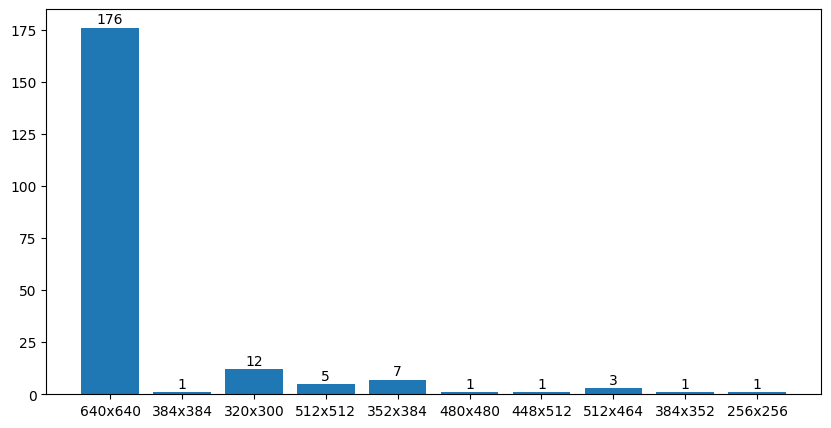

In [48]:
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(x, y)
for a, b in zip(x, y):
    plt.text(a, b + 0.5, b, ha="center", va="bottom")

In [1]:
import pandas as pd
from os.path import join
import os

In [2]:
folder = "/home/yeep/dataset/3d/SPH/"
img_folder = join(folder, "imagesTr")
mask_folder = join(folder, "labelsTr")

In [3]:
dt = {}

In [4]:
dt["image"] = sorted(os.listdir(img_folder))
dt["label"] = sorted(os.listdir(img_folder))

In [5]:
pd.DataFrame(dt).to_excel("1.xlsx", index=None)

In [6]:
import SimpleITK as sitk

In [7]:
img_obj = sitk.ReadImage(join(img_folder, dt["image"][0]))

In [8]:
img_obj.GetOrigin()

(-150.0531005859375, -139.4759063720703, -115.66862487792969)

In [8]:
def spacing_counter(img_path):
    spacing = []
    for p in img_path:
        img_obj = sitk.ReadImage(join(img_folder, p))
        spacing.append(img_obj.GetSpacing())
    spacing = map(lambda x: (round(x[0], 3), round(x[1], 3), round(x[2], 3)), spacing)
    spacing2 = map(lambda x: (x[0], x[1]), spacing)
    return sorted(Counter(spacing2).items(), key=lambda x: x[1], reverse=True)

In [9]:
spacing = []
for p in dt["image"]:
    import matplotlib.pyplot as plt
    from collections import Counter

    img_obj = sitk.ReadImage(join(img_folder, p))
    spacing.append(img_obj.GetSpacing())
    spacing = map(lambda x: (round(x[0], 3), round(x[1], 3), round(x[2], 3)), spacing)
    spacing2 = map(lambda x: (x[0], x[1]), spacing)
    print(sorted(Counter(spacing).items(), key=lambda x: x[1], reverse=True))

In [21]:
spacing = map(lambda x: (round(x[0], 3), round(x[1], 3), round(x[2], 3)), spacing)

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

spacing2 = map(lambda x: (x[0], x[1]), spacing)
sorted(Counter(spacing).items(), key=lambda x: x[1], reverse=True)

[((0.359, 0.359, 6.5), 125),
 ((0.45, 0.45, 6.0), 10),
 ((0.359, 0.359, 7.75), 8),
 ((0.467, 0.467, 6.0), 4),
 ((0.9, 0.9, 4.0), 4),
 ((0.486, 0.486, 7.75), 3),
 ((0.664, 0.664, 6.0), 3),
 ((0.52, 0.52, 7.2), 3),
 ((0.406, 0.406, 6.5), 3),
 ((0.398, 0.398, 4.8), 2),
 ((0.779, 0.779, 6.0), 2),
 ((0.43, 0.43, 5.0), 2),
 ((0.359, 0.359, 5.85), 2),
 ((0.45, 0.45, 6.25), 2),
 ((0.477, 0.477, 6.0), 2),
 ((0.486, 0.486, 6.5), 1),
 ((0.398, 0.398, 6.0), 1),
 ((0.607, 0.607, 7.75), 1),
 ((0.81, 0.81, 7.2), 1),
 ((0.391, 0.391, 6.5), 1),
 ((0.81, 0.81, 6.0), 1),
 ((0.433, 0.433, 6.0), 1),
 ((0.488, 0.488, 5.2), 1),
 ((0.81, 0.81, 6.65), 1),
 ((0.486, 0.486, 7.2), 1),
 ((0.466, 0.466, 6.0), 1),
 ((0.449, 0.449, 6.5), 1),
 ((0.996, 0.996, 6.25), 1),
 ((0.359, 0.359, 5.2), 1),
 ((0.458, 0.458, 5.407), 1),
 ((0.934, 0.934, 3.0), 1),
 ((0.469, 0.469, 6.0), 1),
 ((0.9, 0.9, 3.0), 1),
 ((0.934, 0.934, 4.0), 1),
 ((0.45, 0.45, 4.8), 1),
 ((0.831, 0.831, 3.0), 1),
 ((0.422, 0.422, 6.5), 1),
 ((0.938, 0.9

In [25]:
dt = list(map(lambda x: (f"{x[0][0]} {x[0][1]} {x[0][1]}", x[1]), Counter(spacing).items()))

In [26]:
dt

[]

<BarContainer object of 97 artists>

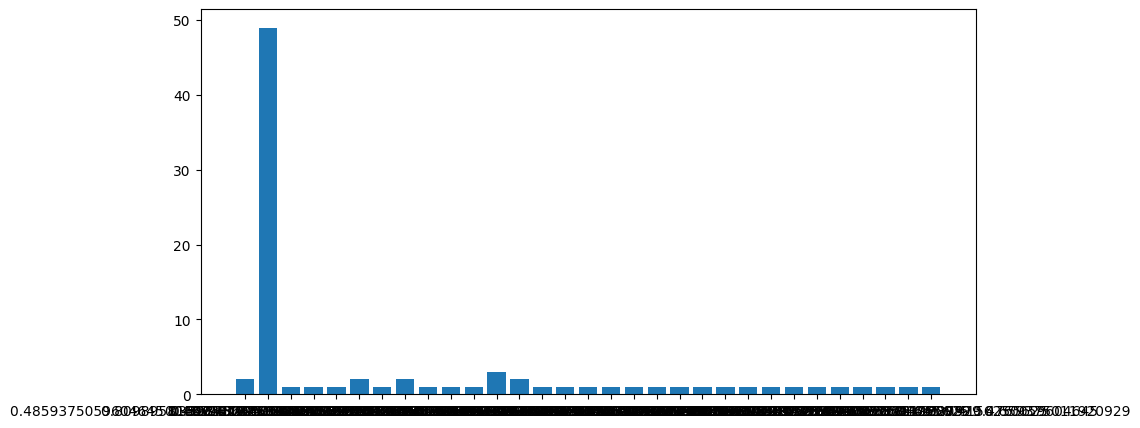

In [33]:
x, y = list(zip(*dt))
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(x, height=y)

In [19]:
Counter(spacing)

NameError: name 'Counter' is not defined

In [5]:
import os
import sys
import numpy as np
import SimpleITK as sitk
from util import get_largest_k_components
from scipy import ndimage
from pymic.util.image_process import *
from os.path import join

In [27]:
def resize_ND_volume_to_given_shape(volume, out_shape, order=3):
    shape0 = volume.shape
    assert (len(shape0) == len(out_shape))
    scale = [(out_shape[i] + 0.0) / shape0[i] for i in range(len(shape0))]
    return ndimage.zoom(volume, scale, order=order)

In [28]:
def label_smooth(volume):
    [D, H, W] = volume.shape
    print(volume.shape)
    s = ndimage.generate_binary_structure(2, 1)
    for d in range(D):
        if (volume[d].sum() > 0):
            volume_d = get_largest_k_components(volume[d], k=3)
            print(d, volume_d.sum())
            if (volume_d.sum() < 10):
                volume[d] = np.zeros_like(volume[d])
                continue
            volume_d = ndimage.binary_closing(volume_d, s)
            volume_d = ndimage.binary_opening(volume_d, s)
            volume[d] = volume_d
    return volume

In [29]:
def image_resample_crop(input_img_name, input_lab_name, output_img_name, output_lab_name):
    img_obj = sitk.ReadImage(input_img_name)
    origin = img_obj.GetOrigin()
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    img_data = sitk.GetArrayFromImage(img_obj)
    img_shape = img_data.shape

    if (len(img_shape) == 4):
        img_data = img_data[0]
        img_shape = img_data.shape
        direction = np.asarray(direction)
        direction = np.reshape(direction, (4, 4))
        direction = direction[0:3, 0:3]
        direction = np.reshape(direction, 9)

    lab_obj = sitk.ReadImage(input_lab_name)
    lab_data = sitk.GetArrayFromImage(lab_obj)
    lab_data = np.asarray(lab_data, np.float32)

    new_shape = [int(img_shape[i] * spacing[2 - i]) for i in range(3)]
    out_data = resize_ND_volume_to_given_shape(img_data, new_shape, order=3)

    out_lab = resize_ND_volume_to_given_shape(lab_data, new_shape, order=3)
    out_lab = out_lab > 0.5
    out_lab = label_smooth(out_lab)
    out_lab = np.asarray(out_lab, np.uint8)
    #
    # # crop the image to [100, 120, 120]
    # offset = [50, 60, 60]
    # bb_min, bb_max = get_ND_bounding_box(out_lab)
    # dim = len(bb_min)
    # center  = [int((bb_min[i] + bb_max[i])/2) for i in range(dim)]
    # bb_min1 = [max(0, center[i] - offset[i]) for i in range(dim)]
    # bb_max1 = [min(out_data.shape[i], center[i] + offset[i]) for i in range(dim)]
    # out_data = crop_ND_volume_with_bounding_box(out_data, bb_min1, bb_max1)
    # out_lab  = crop_ND_volume_with_bounding_box(out_lab, bb_min1, bb_max1)

    out_obj = sitk.GetImageFromArray(out_data)
    out_obj.SetOrigin(origin)
    out_obj.SetSpacing([1.0, 1.0, 1.0])
    out_obj.SetDirection(direction)

    out_lab_obj = sitk.GetImageFromArray(out_lab)
    out_lab_obj.SetOrigin(origin)
    out_lab_obj.SetSpacing([1.0, 1.0, 1.0])
    out_lab_obj.SetDirection(direction)

    sitk.WriteImage(out_obj, output_img_name)
    sitk.WriteImage(out_lab_obj, output_lab_name)

In [25]:
file_name = "/home/yeep/dataset/3d/SPH"
img_folder = join(file_name, "imagesTr")
mask_folder = join(file_name, "labelsTr")

output_dir = join(file_name, "preprocessed")
output_img_folder = join(output_dir, "image")
output_mask_folder = join(output_dir, "label")

In [26]:
for p in os.listdir(img_folder):
    imgpath = join(img_folder, p)
    maskpath = join(mask_folder, p)

    output_imgpath = join(output_img_folder, p)
    output_maskpath = join(output_mask_folder, p)

    image_resample_crop(imgpath, maskpath, output_imgpath, output_maskpath)

(292, 230, 230)
195 141
196 783
197 793
198 798
199 803
200 806
201 814
202 973
203 880
204 882
205 879
206 878
207 875
208 897
209 688
210 686
211 683
212 683
213 683
214 679
215 376
216 302
217 301
218 300
219 298
220 297
221 294
222 95


/tmp/ipykernel_31253/3749469891.py:12: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  volume_d = ndimage.morphology.binary_closing(volume_d, s)
/tmp/ipykernel_31253/3749469891.py:13: DeprecationWarning: Please use `binary_opening` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  volume_d = ndimage.morphology.binary_opening(volume_d, s)


(263, 230, 230)
134 192
135 221
136 225
137 229
138 229
139 229
140 319
141 330
142 330
143 328
144 329
145 335
146 468
147 514
148 520
149 519
150 518
151 522
152 590
153 600
154 604
155 606
156 607
157 606
158 637
159 633
160 633
161 634
162 631
163 633
164 601
165 595
166 594
167 592
168 593
169 592
170 770
171 797
172 797
173 799
174 802
175 812
176 1126
177 1158
178 1164
179 1166
180 1164
181 1162
182 1251
183 1235
184 1236
185 1237
186 1236
187 1248
188 1185
189 1140
190 1138
191 1136
192 1131
193 1125
194 52
(260, 230, 230)
163 284
164 290
165 294
166 299
167 301
168 305
169 313
170 518
171 524
172 526
173 527
174 530
175 533
176 715
177 797
178 800
179 802
180 805
181 809
182 826
183 851
184 793
185 790
186 790
187 788
188 783
189 771
190 257
191 256
192 254
193 254
194 252
195 251
196 6
(245, 288, 288)
131 10
132 175
133 178
134 180
135 186
136 188
137 213
138 340
139 342
140 344
141 347
142 348
143 364
144 464
145 466
146 472
147 471
148 474
149 478
150 667
151 672
152 673
15

In [52]:
import SimpleITK as sitk
import pandas as pd

In [62]:
df = pd.read_excel("1.xlsx", index_col="image")

In [63]:
import json
from os.path import basename

base_folder = "/home/yeep/dataset/3d/SPH"
with open(base_folder + "/data.json") as fp:
    des = json.load(fp)

In [49]:
train, val, test = [], [], []
for item in des["train"]:
    train.append(basename(item["image"]))

for item in des["val"]:
    val.append(basename(item["image"]))

for item in des["test"]:
    test.append(basename(item["image"]))

In [ ]:
for iitem in train:
    img, label = sitk.ReadImage(folder + "/imageTr/" + item)
    start, end = df.loc["MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "start"], df.loc[
        "MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "end"]  #%%
import json

import nibabel as nib
import os

In [ ]:
data_folder = "/home/yeep/dataset/3d/SPH"
img_folder, mask_folder = data_folder + "/imagesTr", data_folder + "/labelsTr"
img_names = os.listdir(img_folder)

In [ ]:
mindim0, mindim1, mindim2 = float("inf"), float("inf"), float("inf")
maxdim0, maxdim1, maxdim2 = -1, -1, -1
slices = []
for name in img_names:
    img = nib.load(img_folder + "/" + name).get_fdata()
    mindim0 = min(img.shape[0], mindim0)
    mindim1 = min(img.shape[1], mindim1)
    mindim2 = min(img.shape[2], mindim2)
    slices.append(img.shape[2])
    maxdim0 = max(img.shape[0], maxdim0)
    maxdim1 = max(img.shape[1], maxdim1)
    maxdim2 = max(img.shape[2], maxdim2)

In [ ]:
mindim0, mindim1, mindim2

In [ ]:
maxdim0, maxdim1, maxdim2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
plt.hist(slices)

In [ ]:
pixel_mask = []
for name in os.listdir(mask_folder):
    mask = nib.load(mask_folder + "/" + name).get_fdata()
    for idx in range(mask.shape[-1]):
        mask[mask >= 1] = 1
        pixel = mask[:, :, idx].sum()
        pixel_mask.append(pixel / mask.shape[0] / mask.shape[1])

In [ ]:
a = np.array(sorted(pixel_mask))

In [ ]:
a.size, np.count_nonzero(a), a.size - np.count_nonzero(a)

In [ ]:
plt.hist(a[6312:])

# 预处理

In [ ]:
import SimpleITK as sitk
import random

In [ ]:
slice_per_volume = 10

In [ ]:
class MedicalImageDeal(object):
    def __init__(self, img, percent=1):
        self.img = img
        self.percent = percent

    @property
    def valid_img(self):
        from skimage import exposure
        cdf = exposure.cumulative_distribution(self.img)
        watershed = cdf[1][cdf[0] >= self.percent][0]
        return np.clip(self.img, self.img.min(), watershed)

    @property
    def norm_img(self):
        return (self.img - self.img.min()) / (self.img.max() - self.img.min())

In [ ]:
def rand_uniform_select(axial_len, select=25):
    assert axial_len >= select
    slices = np.arange(select)
    uniform_sample = np.unique(np.random.uniform(0, axial_len, size=select).astype(np.uint8))
    xorld = np.setdiff1d(slices, uniform_sample)
    random_sampler = np.random.choice(xorld, select - len(uniform_sample), replace=False)
    return sorted([*uniform_sample, *random_sampler])

In [ ]:
import json
import SimpleITK as sitk
import cv2

with open(f"{data_folder}/data.json") as fp:
    jsondes = json.load(fp)

In [ ]:
file_names = jsondes["train"]
file_names

In [ ]:
for name in file_names:
    image_path = f'{data_folder}/{name["image"]}'
    mask_path = f'{data_folder}/{name["label"]}'
    print(f"load {name} into memory")
    img, mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path)), sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    # 排除离群点
    img = MedicalImageDeal(img, percent=0.99).valid_img
    # 强度标准化
    img = (img - img.mean()) / img.std()
    # 选择切片
    slices = rand_uniform_select(img.shape[0], slice_per_volume)
    for select in slices:
        img_slice, mask_slice = img[select], mask[select] >= 1
        # 极大极小归一
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
        img_slice, mask_slice = (img_slice * 255).astype(np.uint8), (mask_slice * 255).astype(np.uint8)
        filename = os.path.basename(name["label"])
        cv2.imwrite("/home/yeep/桌面/sph/train/image/" + filename.split(".")[0] + f"_{select}.jpg", img_slice)
        cv2.imwrite("/home/yeep/桌面/sph/train/label/" + filename.split(".")[0] + f"_{select}.jpg", mask_slice)

In [ ]:
for name in file_names:
    image_path = f'{data_folder}/{name["image"]}'
    mask_path = f'{data_folder}/{name["label"]}'
    print(f"load {name} into memory")
    img, mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path)), sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    # 排除离群点
    img = MedicalImageDeal(img, percent=0.99).valid_img
    # 强度标准化
    img = (img - img.mean()) / img.std()
    # 选择切片
    for select in range(img.shape[0]):
        filename = os.path.basename(name["label"])
        file = "/home/yeep/桌面/sph/train/image/" + filename.split(".")[0] + f"_{select}.jpg"
        if os.path.exists(file):
            continue
        img_slice, mask_slice = img[select], mask[select] >= 1
        # 极大极小归一
        if mask_slice.sum() > 0:
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
            img_slice, mask_slice = (img_slice * 255).astype(np.uint8), (mask_slice * 255).astype(np.uint8)
            cv2.imwrite(file, img_slice)
            cv2.imwrite("/home/yeep/桌面/sph/train/label/" + filename.split(".")[0] + f"_{select}.jpg", mask_slice)

In [ ]:
import json, os

In [ ]:
with open("/home/yeep/dataset/3d/SPH/data.json", "r") as fp:
    des = json.load(fp)

In [ ]:
for name in des["val"]:
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['image']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/val/image/{os.path.basename(name['image'])}")
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['label']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/val/label/{os.path.basename(name['label'])}")

In [ ]:
for name in des["test"]:
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['image']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/test/image/{os.path.basename(name['image'])}")
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['label']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/test/label/{os.path.basename(name['label'])}")

In [ ]:
import json

In [ ]:
with open("/home/yeep/dataset/3d/SPH/data.json", "r") as fp:
    txt = json.load(fp)

In [ ]:
txt["train"].__len__(), txt["test"].__len__(), txt["val"].__len__()

In [ ]:
data_folder = "/home/yeep/dataset/3d/SPH"
img_folder, mask_folder = data_folder + "/imagesTr", data_folder + "/labelsTr"
img_names = os.listdir(img_folder)

In [ ]:
slicesshape = []
for i in img_names:
    img = nib.load(f"{img_folder}/{i}").get_fdata()
    slicesshape.append(f"{img.shape[0]}x{img.shape[1]}")

In [ ]:
from collections import Counter

In [ ]:
x, y = zip(*Counter(slicesshape).items())

In [ ]:
x, y

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(x, y)
for a, b in zip(x, y):
    plt.text(a, b + 0.5, b, ha="center", va="bottom")

In [ ]:
import pandas as pd
from os.path import join
import os

In [ ]:
folder = "/home/yeep/dataset/3d/SPH/"
img_folder = join(folder, "imagesTr")
mask_folder = join(folder, "labelsTr")

In [ ]:
dt = {}

In [ ]:
dt["image"] = sorted(os.listdir(img_folder))
dt["label"] = sorted(os.listdir(img_folder))

In [ ]:
pd.DataFrame(dt).to_excel("1.xlsx", index=None)

In [ ]:
import SimpleITK as sitk

In [ ]:
img_obj = sitk.ReadImage(join(img_folder, dt["image"][0]))

In [ ]:
img_obj.GetOrigin()

In [ ]:
spacing = []
for p in dt["image"]:
    img_obj = sitk.ReadImage(join(img_folder, p))
    spacing.append(img_obj.GetSpacing())

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from collections import Counter

In [ ]:
sorted(Counter(spacing).items(), key=lambda x: x[1], reverse=True)

In [ ]:
dt = list(map(lambda x: (f"{x[0][0]} {x[0][1]} {x[0][1]}", x[1]), Counter(spacing).items()))

In [ ]:
dt

In [ ]:
x, y = list(zip(*dt))
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(x, height=y)

In [ ]:
Counter(spacing)

In [37]:
import os
import sys
import numpy as np
import SimpleITK as sitk
from util import get_largest_k_components
from scipy import ndimage
from pymic.util.image_process import *
from os.path import join

In [38]:
def resize_ND_volume_to_given_shape(volume, out_shape, order=3):
    shape0 = volume.shape
    assert (len(shape0) == len(out_shape))
    scale = [(out_shape[i] + 0.0) / shape0[i] for i in range(len(shape0))]
    return ndimage.zoom(volume, scale, order=order)

In [39]:
def label_smooth(volume):
    [D, H, W] = volume.shape
    print(volume.shape)
    s = ndimage.generate_binary_structure(2, 1)
    for d in range(D):
        if (volume[d].sum() > 0):
            volume_d = get_largest_k_components(volume[d], k=3)
            print(d, volume_d.sum())
            if (volume_d.sum() < 10):
                volume[d] = np.zeros_like(volume[d])
                continue
            volume_d = ndimage.binary_closing(volume_d, s)
            volume_d = ndimage.binary_opening(volume_d, s)
            volume[d] = volume_d
    return volume

In [ ]:
def image_resample_crop(input_img_name, input_lab_name, output_img_name, output_lab_name):
    img_obj = sitk.ReadImage(input_img_name)
    origin = img_obj.GetOrigin()
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    img_data = sitk.GetArrayFromImage(img_obj)
    img_shape = img_data.shape

    if (len(img_shape) == 4):
        img_data = img_data[0]
        img_shape = img_data.shape
        direction = np.asarray(direction)
        direction = np.reshape(direction, (4, 4))
        direction = direction[0:3, 0:3]
        direction = np.reshape(direction, 9)

    lab_obj = sitk.ReadImage(input_lab_name)
    lab_data = sitk.GetArrayFromImage(lab_obj)
    lab_data = np.asarray(lab_data, np.float32)

    new_shape = [int(img_shape[i] * spacing[2 - i]) for i in range(3)]
    out_data = resize_ND_volume_to_given_shape(img_data, new_shape, order=3)

    out_lab = resize_ND_volume_to_given_shape(lab_data, new_shape, order=3)
    out_lab = out_lab > 0.5
    out_lab = label_smooth(out_lab)
    out_lab = np.asarray(out_lab, np.uint8)
    #
    # # crop the image to [100, 120, 120]
    # offset = [50, 60, 60]
    # bb_min, bb_max = get_ND_bounding_box(out_lab)
    # dim = len(bb_min)
    # center  = [int((bb_min[i] + bb_max[i])/2) for i in range(dim)]
    # bb_min1 = [max(0, center[i] - offset[i]) for i in range(dim)]
    # bb_max1 = [min(out_data.shape[i], center[i] + offset[i]) for i in range(dim)]
    # out_data = crop_ND_volume_with_bounding_box(out_data, bb_min1, bb_max1)
    # out_lab  = crop_ND_volume_with_bounding_box(out_lab, bb_min1, bb_max1)

    out_obj = sitk.GetImageFromArray(out_data)
    out_obj.SetOrigin(origin)
    out_obj.SetSpacing([1.0, 1.0, 1.0])
    out_obj.SetDirection(direction)

    out_lab_obj = sitk.GetImageFromArray(out_lab)
    out_lab_obj.SetOrigin(origin)
    out_lab_obj.SetSpacing([1.0, 1.0, 1.0])
    out_lab_obj.SetDirection(direction)

    sitk.WriteImage(out_obj, output_img_name)
    sitk.WriteImage(out_lab_obj, output_lab_name)

In [ ]:
file_name = "/home/yeep/dataset/3d/SPH"
img_folder = join(file_name, "imagesTr")
mask_folder = join(file_name, "labelsTr")

output_dir = join(file_name, "preprocessed")
output_img_folder = join(output_dir, "image")
output_mask_folder = join(output_dir, "label")

In [ ]:
for p in os.listdir(img_folder):
    imgpath = join(img_folder, p)
    maskpath = join(mask_folder, p)

    output_imgpath = join(output_img_folder, p)
    output_maskpath = join(output_mask_folder, p)

    image_resample_crop(imgpath, maskpath, output_imgpath, output_maskpath)

In [1]:
import SimpleITK as sitk
import pandas as pd

In [2]:
df = pd.read_excel("1.xlsx", index_col="image")

In [31]:
import json
from os.path import basename
from scipy import ndimage

base_folder = "/home/yeep/dataset/3d/SPH"
with open(base_folder + "/data.json") as fp:
    des = json.load(fp)

In [32]:
train, val, test = [], [], []
for item in des["train"]:
    train.append(basename(item["image"]))

for item in des["val"]:
    val.append(basename(item["image"]))

for item in des["test"]:
    test.append(basename(item["image"]))

In [44]:
for item in train:
    img, label = sitk.ReadImage(base_folder + "/imagesTr/" + item), sitk.ReadImage(base_folder + "/labelsTr/" + item)
    start, end = df.loc["MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "start"], df.loc[
        "MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "end"]

    origin, direction, spacing = img.GetOrigin(), img.GetDirection(), img.GetSpacing()
    img_numpy, label_numpy = sitk.GetArrayFromImage(img), sitk.GetArrayFromImage(label)
    new_shape = [int(img_numpy.shape[i] * spacing[2 - i]) for i in range(3)]
    new_shape[0] = img_numpy.shape[0]

    img_out = resize_ND_volume_to_given_shape(img_numpy, new_shape)

    out_lab = resize_ND_volume_to_given_shape(label_numpy, new_shape)
    out_lab = out_lab > 0.5
    out_lab = label_smooth(out_lab)
    out_lab = np.asarray(out_lab, np.uint8)

    out_obj = sitk.GetImageFromArray(img_out)
    out_obj.SetOrigin(origin)
    out_obj.SetSpacing([1.0, 1.0, img_numpy.shape[0]])
    out_obj.SetDirection(direction)

    out_lab_obj = sitk.GetImageFromArray(out_lab)
    out_lab_obj.SetOrigin(origin)
    out_lab_obj.SetSpacing([1.0, 1.0, img_numpy.shape[0]])
    out_lab_obj.SetDirection(direction)

    output_img_name, output_lab_name = f"preprocessed/train/imagesTr/{item}", f"preprocessed/train/labelsTr/{item}"
    sitk.WriteImage(out_obj, output_img_name)
    sitk.WriteImage(out_lab_obj, output_lab_name)

(35, 230, 230)
15 159
16 175
17 473
18 873
19 849
20 931
21 1131
22 1932
23 3044
24 2774
25 2323
26 1854
27 807
(40, 230, 230)
23 37
24 90
25 154
26 227
27 797
28 981
29 1536
30 1833
31 787
32 310
(36, 220, 220)
23 32
24 121
25 245
26 333
27 625
28 629
29 720
30 354
(33, 230, 230)
20 99
21 127
22 79
23 205
24 657
25 742
26 422
(35, 230, 230)
23 315
24 459
25 680
26 383
27 250
(35, 230, 230)
22 118
23 638
24 639
25 850
26 1132
27 1498
28 1504
29 1126
(35, 230, 230)
22 45
23 164
24 426
25 737
26 785
27 1527
28 1229
29 688
30 167
(35, 230, 230)
25 171
26 720
27 889
28 705
29 763
30 293
(35, 230, 230)
18 587
19 581
20 703
21 798
22 1327
23 1914
24 2160
25 1975
26 2210
27 1937
28 2622
29 1422
30 1213
(37, 230, 230)
25 13
26 192
27 494
28 836
29 1204
30 1062
31 781
(35, 230, 230)
21 149
22 537
23 591
24 856
25 875
26 430
(34, 230, 230)
22 138
23 340
24 454
25 656
26 1223
27 1406
28 1605
29 1523
30 673
(35, 230, 230)
23 155
24 382
25 925
26 1026
27 1007
28 1576
29 980
(35, 230, 230)
20 176
21

In [ ]:
for item in train:
    img, label = sitk.ReadImage(base_folder + "/imagesTr/" + item), sitk.ReadImage(base_folder + "/labelsTr/" + item)
    start, end = df.loc["MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "start"], df.loc[
        "MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "end"]

    origin, direction, spacing = img.GetOrigin(), img.GetDirection(), img.GetSpacing()
    img_numpy, label_numpy = sitk.GetArrayFromImage(img), sitk.GetArrayFromImage(label)
    img_numpy = MedicalImageDeal(img_numpy).valid_img
    img_numpy = (img_numpy - img_numpy.min()) / (img_numpy.max() - img_numpy.min())

    output_img_name, output_lab_name = f"preprocessed/train/imagesTr/", f"preprocessed/train/labelsTr/"
    for i in range(start, end + 1):
        img_path, mask_path = f"preprocessed/train/imagesTr/slice{i}_{item}", f"preprocessed/train/labelsTr/slice{i}_{item}"
        img, mask = img_numpy[i], label_numpy[i]  #%%

In [ ]:
data_folder = "/home/yeep/dataset/3d/SPH"
img_folder, mask_folder = data_folder + "/imagesTr", data_folder + "/labelsTr"
img_names = os.listdir(img_folder)

In [ ]:
mindim0, mindim1, mindim2 = float("inf"), float("inf"), float("inf")
maxdim0, maxdim1, maxdim2 = -1, -1, -1
slices = []
for name in img_names:
    img = nib.load(img_folder + "/" + name).get_fdata()
    mindim0 = min(img.shape[0], mindim0)
    mindim1 = min(img.shape[1], mindim1)
    mindim2 = min(img.shape[2], mindim2)
    slices.append(img.shape[2])
    maxdim0 = max(img.shape[0], maxdim0)
    maxdim1 = max(img.shape[1], maxdim1)
    maxdim2 = max(img.shape[2], maxdim2)

In [ ]:
mindim0, mindim1, mindim2

In [ ]:
maxdim0, maxdim1, maxdim2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
plt.hist(slices)

In [ ]:
pixel_mask = []
for name in os.listdir(mask_folder):
    mask = nib.load(mask_folder + "/" + name).get_fdata()
    for idx in range(mask.shape[-1]):
        mask[mask >= 1] = 1
        pixel = mask[:, :, idx].sum()
        pixel_mask.append(pixel / mask.shape[0] / mask.shape[1])

In [ ]:
a = np.array(sorted(pixel_mask))

In [ ]:
a.size, np.count_nonzero(a), a.size - np.count_nonzero(a)

In [ ]:
plt.hist(a[6312:])

# 预处理

In [ ]:
import SimpleITK as sitk
import random

In [ ]:
slice_per_volume = 10

In [ ]:
class MedicalImageDeal(object):
    def __init__(self, img, percent=1):
        self.img = img
        self.percent = percent

    @property
    def valid_img(self):
        from skimage import exposure
        cdf = exposure.cumulative_distribution(self.img)
        watershed = cdf[1][cdf[0] >= self.percent][0]
        return np.clip(self.img, self.img.min(), watershed)

    def norm_img(self, img):
        return (img - img.min()) / (img.max() - img.min())

In [ ]:
def rand_uniform_select(axial_len, select=25):
    assert axial_len >= select
    slices = np.arange(select)
    uniform_sample = np.unique(np.random.uniform(0, axial_len, size=select).astype(np.uint8))
    xorld = np.setdiff1d(slices, uniform_sample)
    random_sampler = np.random.choice(xorld, select - len(uniform_sample), replace=False)
    return sorted([*uniform_sample, *random_sampler])

In [ ]:
import json
import SimpleITK as sitk
import cv2

with open(f"{data_folder}/data.json") as fp:
    jsondes = json.load(fp)

In [ ]:
file_names = jsondes["train"]
file_names

In [ ]:
for name in file_names:
    image_path = f'{data_folder}/{name["image"]}'
    mask_path = f'{data_folder}/{name["label"]}'
    print(f"load {name} into memory")
    img, mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path)), sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    # 排除离群点
    img = MedicalImageDeal(img, percent=0.99).valid_img
    # 强度标准化
    img = (img - img.mean()) / img.std()
    # 选择切片
    slices = rand_uniform_select(img.shape[0], slice_per_volume)
    for select in slices:
        img_slice, mask_slice = img[select], mask[select] >= 1
        # 极大极小归一
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
        img_slice, mask_slice = (img_slice * 255).astype(np.uint8), (mask_slice * 255).astype(np.uint8)
        filename = os.path.basename(name["label"])
        cv2.imwrite("/home/yeep/桌面/sph/train/image/" + filename.split(".")[0] + f"_{select}.jpg", img_slice)
        cv2.imwrite("/home/yeep/桌面/sph/train/label/" + filename.split(".")[0] + f"_{select}.jpg", mask_slice)

In [ ]:
for name in file_names:
    image_path = f'{data_folder}/{name["image"]}'
    mask_path = f'{data_folder}/{name["label"]}'
    print(f"load {name} into memory")
    img, mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path)), sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    # 排除离群点
    img = MedicalImageDeal(img, percent=0.99).valid_img
    # 强度标准化
    img = (img - img.mean()) / img.std()
    # 选择切片
    for select in range(img.shape[0]):
        filename = os.path.basename(name["label"])
        file = "/home/yeep/桌面/sph/train/image/" + filename.split(".")[0] + f"_{select}.jpg"
        if os.path.exists(file):
            continue
        img_slice, mask_slice = img[select], mask[select] >= 1
        # 极大极小归一
        if mask_slice.sum() > 0:
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
            img_slice, mask_slice = (img_slice * 255).astype(np.uint8), (mask_slice * 255).astype(np.uint8)
            cv2.imwrite(file, img_slice)
            cv2.imwrite("/home/yeep/桌面/sph/train/label/" + filename.split(".")[0] + f"_{select}.jpg", mask_slice)

In [ ]:
import json, os

In [ ]:
with open("/home/yeep/dataset/3d/SPH/data.json", "r") as fp:
    des = json.load(fp)

In [ ]:
for name in des["val"]:
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['image']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/val/image/{os.path.basename(name['image'])}")
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['label']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/val/label/{os.path.basename(name['label'])}")

In [ ]:
for name in des["test"]:
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['image']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/test/image/{os.path.basename(name['image'])}")
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['label']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/test/label/{os.path.basename(name['label'])}")

In [ ]:
import json

In [ ]:
with open("/home/yeep/dataset/3d/SPH/data.json", "r") as fp:
    txt = json.load(fp)

In [ ]:
txt["train"].__len__(), txt["test"].__len__(), txt["val"].__len__()

In [ ]:
data_folder = "/home/yeep/dataset/3d/SPH"
img_folder, mask_folder = data_folder + "/imagesTr", data_folder + "/labelsTr"
img_names = os.listdir(img_folder)

In [ ]:
slicesshape = []
for i in img_names:
    img = nib.load(f"{img_folder}/{i}").get_fdata()
    slicesshape.append(f"{img.shape[0]}x{img.shape[1]}")

In [ ]:
from collections import Counter

In [ ]:
x, y = zip(*Counter(slicesshape).items())

In [ ]:
x, y

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(x, y)
for a, b in zip(x, y):
    plt.text(a, b + 0.5, b, ha="center", va="bottom")

In [ ]:
import pandas as pd
from os.path import join
import os

In [ ]:
folder = "/home/yeep/dataset/3d/SPH/"
img_folder = join(folder, "imagesTr")
mask_folder = join(folder, "labelsTr")

In [ ]:
dt = {}

In [ ]:
dt["image"] = sorted(os.listdir(img_folder))
dt["label"] = sorted(os.listdir(img_folder))

In [ ]:
pd.DataFrame(dt).to_excel("1.xlsx", index=None)

In [ ]:
import SimpleITK as sitk

In [ ]:
img_obj = sitk.ReadImage(join(img_folder, dt["image"][0]))

In [ ]:
img_obj.GetOrigin()

In [ ]:
spacing = []
for p in dt["image"]:
    img_obj = sitk.ReadImage(join(img_folder, p))
    spacing.append(img_obj.GetSpacing())

In [ ]:
spacing = map(lambda x: (round(x[0], 3), round(x[1], 3), round(x[2], 3)), spacing)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from collections import Counter

In [ ]:
spacing2 = map(lambda x: (x[0], x[1]), spacing)

In [ ]:
sorted(Counter(spacing).items(), key=lambda x: x[1], reverse=True)

In [ ]:
dt = list(map(lambda x: (f"{x[0][0]} {x[0][1]} {x[0][1]}", x[1]), Counter(spacing).items()))

In [ ]:
dt

In [ ]:
x, y = list(zip(*dt))
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(x, height=y)

In [ ]:
Counter(spacing)

In [ ]:
import os
import sys
import numpy as np
import SimpleITK as sitk
from util import get_largest_k_components
from scipy import ndimage
from pymic.util.image_process import *
from os.path import join

In [ ]:
def resize_ND_volume_to_given_shape(volume, out_shape, order=3):
    shape0 = volume.shape
    assert (len(shape0) == len(out_shape))
    scale = [(out_shape[i] + 0.0) / shape0[i] for i in range(len(shape0))]
    return ndimage.zoom(volume, scale, order=order)

In [ ]:
def label_smooth(volume):
    [D, H, W] = volume.shape
    print(volume.shape)
    s = ndimage.generate_binary_structure(2, 1)
    for d in range(D):
        if (volume[d].sum() > 0):
            volume_d = get_largest_k_components(volume[d], k=3)
            print(d, volume_d.sum())
            if (volume_d.sum() < 10):
                volume[d] = np.zeros_like(volume[d])
                continue
            volume_d = ndimage.binary_closing(volume_d, s)
            volume_d = ndimage.binary_opening(volume_d, s)
            volume[d] = volume_d
    return volume

In [ ]:
def image_resample_crop(input_img_name, input_lab_name, output_img_name, output_lab_name):
    img_obj = sitk.ReadImage(input_img_name)
    origin = img_obj.GetOrigin()
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    img_data = sitk.GetArrayFromImage(img_obj)
    img_shape = img_data.shape

    if (len(img_shape) == 4):
        img_data = img_data[0]
        img_shape = img_data.shape
        direction = np.asarray(direction)
        direction = np.reshape(direction, (4, 4))
        direction = direction[0:3, 0:3]
        direction = np.reshape(direction, 9)

    lab_obj = sitk.ReadImage(input_lab_name)
    lab_data = sitk.GetArrayFromImage(lab_obj)
    lab_data = np.asarray(lab_data, np.float32)

    new_shape = [int(img_shape[i] * spacing[2 - i]) for i in range(3)]
    out_data = resize_ND_volume_to_given_shape(img_data, new_shape, order=3)

    out_lab = resize_ND_volume_to_given_shape(lab_data, new_shape, order=3)
    out_lab = out_lab > 0.5
    out_lab = label_smooth(out_lab)
    out_lab = np.asarray(out_lab, np.uint8)
    #
    # # crop the image to [100, 120, 120]
    # offset = [50, 60, 60]
    # bb_min, bb_max = get_ND_bounding_box(out_lab)
    # dim = len(bb_min)
    # center  = [int((bb_min[i] + bb_max[i])/2) for i in range(dim)]
    # bb_min1 = [max(0, center[i] - offset[i]) for i in range(dim)]
    # bb_max1 = [min(out_data.shape[i], center[i] + offset[i]) for i in range(dim)]
    # out_data = crop_ND_volume_with_bounding_box(out_data, bb_min1, bb_max1)
    # out_lab  = crop_ND_volume_with_bounding_box(out_lab, bb_min1, bb_max1)

    out_obj = sitk.GetImageFromArray(out_data)
    out_obj.SetOrigin(origin)
    out_obj.SetSpacing([1.0, 1.0, 1.0])
    out_obj.SetDirection(direction)

    out_lab_obj = sitk.GetImageFromArray(out_lab)
    out_lab_obj.SetOrigin(origin)
    out_lab_obj.SetSpacing([1.0, 1.0, 1.0])
    out_lab_obj.SetDirection(direction)

    sitk.WriteImage(out_obj, output_img_name)
    sitk.WriteImage(out_lab_obj, output_lab_name)

In [ ]:
file_name = "/home/yeep/dataset/3d/SPH"
img_folder = join(file_name, "imagesTr")
mask_folder = join(file_name, "labelsTr")

output_dir = join(file_name, "preprocessed")
output_img_folder = join(output_dir, "image")
output_mask_folder = join(output_dir, "label")

In [ ]:
for p in os.listdir(img_folder):
    imgpath = join(img_folder, p)
    maskpath = join(mask_folder, p)

    output_imgpath = join(output_img_folder, p)
    output_maskpath = join(output_mask_folder, p)

    image_resample_crop(imgpath, maskpath, output_imgpath, output_maskpath)

In [ ]:
import SimpleITK as sitk
import pandas as pd

In [ ]:
df = pd.read_excel("1.xlsx", index_col="image")

In [ ]:
import json
from os.path import basename

base_folder = "/home/yeep/dataset/3d/SPH"
with open(base_folder + "/data.json") as fp:
    des = json.load(fp)

In [ ]:
train, val, test = [], [], []
for item in des["train"]:
    train.append(basename(item["image"]))

for item in des["val"]:
    val.append(basename(item["image"]))

for item in des["test"]:
    test.append(basename(item["image"]))

In [ ]:
for iitem in train:
    img, label = sitk.ReadImage(folder + "/imageTr/" + item)
    start, end = df.loc["MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "start"], df.loc[
        "MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "end"]  #%%
import json

import nibabel as nib
import os

In [ ]:
data_folder = "/home/yeep/dataset/3d/SPH"
img_folder, mask_folder = data_folder + "/imagesTr", data_folder + "/labelsTr"
img_names = os.listdir(img_folder)

In [ ]:
mindim0, mindim1, mindim2 = float("inf"), float("inf"), float("inf")
maxdim0, maxdim1, maxdim2 = -1, -1, -1
slices = []
for name in img_names:
    img = nib.load(img_folder + "/" + name).get_fdata()
    mindim0 = min(img.shape[0], mindim0)
    mindim1 = min(img.shape[1], mindim1)
    mindim2 = min(img.shape[2], mindim2)
    slices.append(img.shape[2])
    maxdim0 = max(img.shape[0], maxdim0)
    maxdim1 = max(img.shape[1], maxdim1)
    maxdim2 = max(img.shape[2], maxdim2)

In [ ]:
mindim0, mindim1, mindim2

In [ ]:
maxdim0, maxdim1, maxdim2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
plt.hist(slices)

In [ ]:
pixel_mask = []
for name in os.listdir(mask_folder):
    mask = nib.load(mask_folder + "/" + name).get_fdata()
    for idx in range(mask.shape[-1]):
        mask[mask >= 1] = 1
        pixel = mask[:, :, idx].sum()
        pixel_mask.append(pixel / mask.shape[0] / mask.shape[1])

In [ ]:
a = np.array(sorted(pixel_mask))

In [ ]:
a.size, np.count_nonzero(a), a.size - np.count_nonzero(a)

In [ ]:
plt.hist(a[6312:])

# 预处理

In [ ]:
import SimpleITK as sitk
import random

In [ ]:
slice_per_volume = 10

In [ ]:
class MedicalImageDeal(object):
    def __init__(self, img, percent=1):
        self.img = img
        self.percent = percent

    @property
    def valid_img(self):
        from skimage import exposure
        cdf = exposure.cumulative_distribution(self.img)
        watershed = cdf[1][cdf[0] >= self.percent][0]
        return np.clip(self.img, self.img.min(), watershed)

    @property
    def norm_img(self):
        return (self.img - self.img.min()) / (self.img.max() - self.img.min())

In [ ]:
def rand_uniform_select(axial_len, select=25):
    assert axial_len >= select
    slices = np.arange(select)
    uniform_sample = np.unique(np.random.uniform(0, axial_len, size=select).astype(np.uint8))
    xorld = np.setdiff1d(slices, uniform_sample)
    random_sampler = np.random.choice(xorld, select - len(uniform_sample), replace=False)
    return sorted([*uniform_sample, *random_sampler])

In [ ]:
import json
import SimpleITK as sitk
import cv2

with open(f"{data_folder}/data.json") as fp:
    jsondes = json.load(fp)

In [ ]:
file_names = jsondes["train"]
file_names

In [ ]:
for name in file_names:
    image_path = f'{data_folder}/{name["image"]}'
    mask_path = f'{data_folder}/{name["label"]}'
    print(f"load {name} into memory")
    img, mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path)), sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    # 排除离群点
    img = MedicalImageDeal(img, percent=0.99).valid_img
    # 强度标准化
    img = (img - img.mean()) / img.std()
    # 选择切片
    slices = rand_uniform_select(img.shape[0], slice_per_volume)
    for select in slices:
        img_slice, mask_slice = img[select], mask[select] >= 1
        # 极大极小归一
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
        img_slice, mask_slice = (img_slice * 255).astype(np.uint8), (mask_slice * 255).astype(np.uint8)
        filename = os.path.basename(name["label"])
        cv2.imwrite("/home/yeep/桌面/sph/train/image/" + filename.split(".")[0] + f"_{select}.jpg", img_slice)
        cv2.imwrite("/home/yeep/桌面/sph/train/label/" + filename.split(".")[0] + f"_{select}.jpg", mask_slice)

In [ ]:
for name in file_names:
    image_path = f'{data_folder}/{name["image"]}'
    mask_path = f'{data_folder}/{name["label"]}'
    print(f"load {name} into memory")
    img, mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path)), sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    # 排除离群点
    img = MedicalImageDeal(img, percent=0.99).valid_img
    # 强度标准化
    img = (img - img.mean()) / img.std()
    # 选择切片
    for select in range(img.shape[0]):
        filename = os.path.basename(name["label"])
        file = "/home/yeep/桌面/sph/train/image/" + filename.split(".")[0] + f"_{select}.jpg"
        if os.path.exists(file):
            continue
        img_slice, mask_slice = img[select], mask[select] >= 1
        # 极大极小归一
        if mask_slice.sum() > 0:
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
            img_slice, mask_slice = (img_slice * 255).astype(np.uint8), (mask_slice * 255).astype(np.uint8)
            cv2.imwrite(file, img_slice)
            cv2.imwrite("/home/yeep/桌面/sph/train/label/" + filename.split(".")[0] + f"_{select}.jpg", mask_slice)

In [ ]:
import json, os

In [ ]:
with open("/home/yeep/dataset/3d/SPH/data.json", "r") as fp:
    des = json.load(fp)

In [ ]:
for name in des["val"]:
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['image']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/val/image/{os.path.basename(name['image'])}")
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['label']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/val/label/{os.path.basename(name['label'])}")

In [ ]:
for name in des["test"]:
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['image']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/test/image/{os.path.basename(name['image'])}")
    os.system(
        f"cp /home/yeep/dataset/3d/SPH/{name['label']} /home/yeep/project/py/ceal-random-sample/dataset/proprecess/test/label/{os.path.basename(name['label'])}")

In [ ]:
import json

In [ ]:
with open("/home/yeep/dataset/3d/SPH/data.json", "r") as fp:
    txt = json.load(fp)

In [ ]:
txt["train"].__len__(), txt["test"].__len__(), txt["val"].__len__()

In [ ]:
data_folder = "/home/yeep/dataset/3d/SPH"
img_folder, mask_folder = data_folder + "/imagesTr", data_folder + "/labelsTr"
img_names = os.listdir(img_folder)

In [ ]:
slicesshape = []
for i in img_names:
    img = nib.load(f"{img_folder}/{i}").get_fdata()
    slicesshape.append(f"{img.shape[0]}x{img.shape[1]}")

In [ ]:
from collections import Counter

In [ ]:
x, y = zip(*Counter(slicesshape).items())

In [ ]:
x, y

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(x, y)
for a, b in zip(x, y):
    plt.text(a, b + 0.5, b, ha="center", va="bottom")

In [ ]:
import pandas as pd
from os.path import join
import os

In [ ]:
folder = "/home/yeep/dataset/3d/SPH/"
img_folder = join(folder, "imagesTr")
mask_folder = join(folder, "labelsTr")

In [ ]:
dt = {}

In [ ]:
dt["image"] = sorted(os.listdir(img_folder))
dt["label"] = sorted(os.listdir(img_folder))

In [ ]:
pd.DataFrame(dt).to_excel("1.xlsx", index=None)

In [ ]:
import SimpleITK as sitk

In [ ]:
img_obj = sitk.ReadImage(join(img_folder, dt["image"][0]))

In [ ]:
img_obj.GetOrigin()

In [ ]:
spacing = []
for p in dt["image"]:
    img_obj = sitk.ReadImage(join(img_folder, p))
    spacing.append(img_obj.GetSpacing())

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from collections import Counter

In [ ]:
sorted(Counter(spacing).items(), key=lambda x: x[1], reverse=True)

In [ ]:
dt = list(map(lambda x: (f"{x[0][0]} {x[0][1]} {x[0][1]}", x[1]), Counter(spacing).items()))

In [ ]:
dt

In [ ]:
x, y = list(zip(*dt))
plt.figure(figsize=(10, 5), dpi=100)
plt.bar(x, height=y)

In [ ]:
Counter(spacing)

In [ ]:
import os
import sys
import numpy as np
import SimpleITK as sitk
from util import get_largest_k_components
from scipy import ndimage
from pymic.util.image_process import *
from os.path import join

In [ ]:
def resize_ND_volume_to_given_shape(volume, out_shape, order=3):
    shape0 = volume.shape
    assert (len(shape0) == len(out_shape))
    scale = [(out_shape[i] + 0.0) / shape0[i] for i in range(len(shape0))]
    return ndimage.zoom(volume, scale, order=order)

In [ ]:
def label_smooth(volume):
    [D, H, W] = volume.shape
    print(volume.shape)
    s = ndimage.generate_binary_structure(2, 1)
    for d in range(D):
        if (volume[d].sum() > 0):
            volume_d = get_largest_k_components(volume[d], k=3)
            print(d, volume_d.sum())
            if (volume_d.sum() < 10):
                volume[d] = np.zeros_like(volume[d])
                continue
            volume_d = ndimage.binary_closing(volume_d, s)
            volume_d = ndimage.binary_opening(volume_d, s)
            volume[d] = volume_d
    return volume

In [ ]:
def image_resample_crop(input_img_name, input_lab_name, output_img_name, output_lab_name):
    img_obj = sitk.ReadImage(input_img_name)
    origin = img_obj.GetOrigin()
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    img_data = sitk.GetArrayFromImage(img_obj)
    img_shape = img_data.shape

    if (len(img_shape) == 4):
        img_data = img_data[0]
        img_shape = img_data.shape
        direction = np.asarray(direction)
        direction = np.reshape(direction, (4, 4))
        direction = direction[0:3, 0:3]
        direction = np.reshape(direction, 9)

    lab_obj = sitk.ReadImage(input_lab_name)
    lab_data = sitk.GetArrayFromImage(lab_obj)
    lab_data = np.asarray(lab_data, np.float32)

    new_shape = [int(img_shape[i] * spacing[2 - i]) for i in range(3)]
    out_data = resize_ND_volume_to_given_shape(img_data, new_shape, order=3)

    out_lab = resize_ND_volume_to_given_shape(lab_data, new_shape, order=3)
    out_lab = out_lab > 0.5
    out_lab = label_smooth(out_lab)
    out_lab = np.asarray(out_lab, np.uint8)
    #
    # # crop the image to [100, 120, 120]
    # offset = [50, 60, 60]
    # bb_min, bb_max = get_ND_bounding_box(out_lab)
    # dim = len(bb_min)
    # center  = [int((bb_min[i] + bb_max[i])/2) for i in range(dim)]
    # bb_min1 = [max(0, center[i] - offset[i]) for i in range(dim)]
    # bb_max1 = [min(out_data.shape[i], center[i] + offset[i]) for i in range(dim)]
    # out_data = crop_ND_volume_with_bounding_box(out_data, bb_min1, bb_max1)
    # out_lab  = crop_ND_volume_with_bounding_box(out_lab, bb_min1, bb_max1)

    out_obj = sitk.GetImageFromArray(out_data)
    out_obj.SetOrigin(origin)
    out_obj.SetSpacing([1.0, 1.0, 1.0])
    out_obj.SetDirection(direction)

    out_lab_obj = sitk.GetImageFromArray(out_lab)
    out_lab_obj.SetOrigin(origin)
    out_lab_obj.SetSpacing([1.0, 1.0, 1.0])
    out_lab_obj.SetDirection(direction)

    sitk.WriteImage(out_obj, output_img_name)
    sitk.WriteImage(out_lab_obj, output_lab_name)

In [ ]:
file_name = "/home/yeep/dataset/3d/SPH"
img_folder = join(file_name, "imagesTr")
mask_folder = join(file_name, "labelsTr")

output_dir = join(file_name, "preprocessed")
output_img_folder = join(output_dir, "image")
output_mask_folder = join(output_dir, "label")

In [ ]:
for p in os.listdir(img_folder):
    imgpath = join(img_folder, p)
    maskpath = join(mask_folder, p)

    output_imgpath = join(output_img_folder, p)
    output_maskpath = join(output_mask_folder, p)

    image_resample_crop(imgpath, maskpath, output_imgpath, output_maskpath)

In [66]:
import SimpleITK as sitk
import pandas as pd

In [67]:
df = pd.read_excel("1.xlsx", index_col="image")

In [68]:
import json
from os.path import basename
from scipy import ndimage

base_folder = "/home/yeep/dataset/3d/SPH"
with open(base_folder + "/data.json") as fp:
    des = json.load(fp)

In [69]:
train, val, test = [], [], []
for item in des["train"]:
    train.append(basename(item["image"]))

for item in des["val"]:
    val.append(basename(item["image"]))

for item in des["test"]:
    test.append(basename(item["image"]))

In [57]:
for item in train:
    img, label = sitk.ReadImage(base_folder + "/imagesTr/" + item), sitk.ReadImage(base_folder + "/labelsTr/" + item)
    start, end = df.loc["MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "start"], df.loc[
        "MR1201804290098__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz", "end"]

    origin, direction, spacing = img.GetOrigin(), img.GetDirection(), img.GetSpacing()
    img_numpy, label_numpy = sitk.GetArrayFromImage(img), sitk.GetArrayFromImage(label)
    new_shape = [int(img_numpy.shape[i] * spacing[2 - i]) for i in range(3)]
    new_shape[0] = img_numpy.shape[0]

    img_out = resize_ND_volume_to_given_shape(img_numpy, new_shape)

    out_lab = resize_ND_volume_to_given_shape(label_numpy, new_shape)
    out_lab = out_lab > 0.5
    out_lab = label_smooth(out_lab)
    out_lab = np.asarray(out_lab, np.uint8)

    out_obj = sitk.GetImageFromArray(img_out)
    out_obj.SetOrigin(origin)
    out_obj.SetSpacing([1.0, 1.0, img_numpy.shape[0]])
    out_obj.SetDirection(direction)

    out_lab_obj = sitk.GetImageFromArray(out_lab)
    out_lab_obj.SetOrigin(origin)
    out_lab_obj.SetSpacing([1.0, 1.0, img_numpy.shape[0]])
    out_lab_obj.SetDirection(direction)

    output_img_name, output_lab_name = f"preprocessed/train/imagesTr/{item}", f"preprocessed/train/labelsTr/{item}"
    sitk.WriteImage(out_obj, output_img_name)
    sitk.WriteImage(out_lab_obj, output_lab_name)

(35, 230, 230)
15 159
16 175
17 473
18 873
19 849
20 931
21 1131
22 1932
23 3044
24 2774
25 2323
26 1854
27 807
(40, 230, 230)
23 37
24 90
25 154
26 227
27 797
28 981
29 1536
30 1833
31 787
32 310
(36, 220, 220)
23 32
24 121
25 245
26 333
27 625
28 629
29 720
30 354
(33, 230, 230)
20 99
21 127
22 79
23 205
24 657
25 742
26 422
(35, 230, 230)
23 315
24 459
25 680
26 383
27 250
(35, 230, 230)
22 118
23 638
24 639
25 850
26 1132
27 1498
28 1504
29 1126
(35, 230, 230)
22 45
23 164
24 426
25 737
26 785
27 1527
28 1229
29 688
30 167
(35, 230, 230)
25 171
26 720
27 889
28 705
29 763
30 293
(35, 230, 230)
18 587
19 581
20 703
21 798
22 1327
23 1914
24 2160
25 1975
26 2210
27 1937
28 2622
29 1422
30 1213
(37, 230, 230)
25 13
26 192
27 494
28 836
29 1204
30 1062
31 781
(35, 230, 230)
21 149
22 537
23 591
24 856
25 875
26 430
(34, 230, 230)
22 138
23 340
24 454
25 656
26 1223
27 1406
28 1605
29 1523
30 673
(35, 230, 230)
23 155
24 382
25 925
26 1026
27 1007
28 1576
29 980
(35, 230, 230)
20 176
21

Exception ignored in: <function ZipFile.__del__ at 0x7f4137ef35e0>
Traceback (most recent call last):
  File "/home/yeep/env/miniconda/envs/pymic_al/lib/python3.8/zipfile.py", line 1800, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [71]:
import cv2
import numpy as np

for item in train:
    img, label = sitk.ReadImage(base_folder + "/imagesTr/" + item), sitk.ReadImage(base_folder + "/labelsTr/" + item)
    start, end = df.loc[item, "start"], df.loc[
        item, "end"]

    # origin, direction, spacing = img.GetOrigin(), img.GetDirection(), img.GetSpacing()
    img_numpy, label_numpy = sitk.GetArrayFromImage(img), sitk.GetArrayFromImage(label)
    img_numpy = MedicalImageDeal(img_numpy).valid_img
    img_numpy = (img_numpy - img_numpy.min()) / (img_numpy.max() - img_numpy.min())
    print(item, img_numpy.shape[0], start, end)
    for i in range(start, end + 1):
        img_path, mask_path = f"preprocessed/train/image/{item.split('.')[0]}_slice{i}.png", f"preprocessed/train/label/{item.split('.')[0]}_slice{i}.png"
        img, mask = np.asanyarray(img_numpy[i] * 255, dtype=np.uint8), np.asanyarray(label_numpy[i] * 255,
                                                                                     dtype=np.uint8)
        cv2.imwrite(img_path, img)
        cv2.imwrite(mask_path, mask)

MR1201810170136__t1_fs_tse_rs_tra_0_0_0_axial_20181019.nii.gz 35 12 31
MR1201708280262__t1_fs_tse_rs_tra_0_0_0_axial_20170830.nii.gz 40 19 35
MR1201611180212__T1W_TSE_SPIR+C_0_0_0_axial_20161121.nii.gz 36 14 34
MR1201707200224__t1_fs_tse_rs_tra_0_0_1_axial_20170724.nii.gz 33 15 30
MR1202001210130__t1_fs_tse_rs_tra_0_0_0_axial_20200122.nii.gz 35 17 31
MR1201804110166__t1_fs_tse_rs_tra_0_0_0_axial_20180416.nii.gz 35 13 32
MR1201908070189__t1_fs_tse_rs_tra_0_0_0_axial_20190809.nii.gz 35 13 32
MR1201609050173__t1_fs_tse_rs_tra_0_0_0_axial_20160906.nii.gz 35 16 32
MR1201701180149__t1_fs_tse_rs_tra_0_0_0_axial_20170120.nii.gz 35 13 32
MR1201909120165__t1_fs_tse_rs_tra_0_0_0_axial_20190917.nii.gz 37 19 34
MR1201711030144__t1_fs_tse_rs_tra_0_0_0_axial_20171106.nii.gz 35 12 31
MR1201804290102__t1_fs_tse_rs_tra_0_0_0_axial_20180503.nii.gz 34 13 32
MR1201703240120__t1_fs_tse_rs_tra_0_0_0_axial_20170328.nii.gz 35 15 32
MR1201606290183__t1_fs_tse_rs_tra_0_0_0_axial_20160630.nii.gz 35 15 31
MR120190

In [78]:
import cv2
import numpy as np

for item in val:
    img, label = sitk.ReadImage(base_folder + "/imagesTr/" + item), sitk.ReadImage(base_folder + "/labelsTr/" + item)
    start, end = df.loc[item, "start"], df.loc[item, "end"]
    origin, direction, spacing = img.GetOrigin(), img.GetDirection(), img.GetSpacing()
    img_numpy, label_numpy = sitk.GetArrayFromImage(img), sitk.GetArrayFromImage(label)
    img_numpy = MedicalImageDeal(img_numpy).valid_img
    img_numpy = (img_numpy - img_numpy.min()) / (img_numpy.max() - img_numpy.min())

    print(start, end)
    out_obj = sitk.GetImageFromArray(img_numpy[start:end + 1])
    out_obj.SetOrigin(origin)
    out_obj.SetSpacing(spacing)
    out_obj.SetDirection(direction)

    out_lab_obj = sitk.GetImageFromArray(label_numpy[start:end + 1])
    out_lab_obj.SetOrigin(origin)
    out_lab_obj.SetSpacing(spacing)
    out_lab_obj.SetDirection(direction)
    output_img_name, output_lab_name = f"preprocessed/val/image/{item}", f"preprocessed/val/label/{item}"
    sitk.WriteImage(out_obj, output_img_name)
    sitk.WriteImage(out_lab_obj, output_lab_name)


13 31
15 32
17 32
13 31
20 37
28 56
13 31
13 32
17 31
16 32
16 31
3 25
15 32
15 32
18 36
15 33
15 34
15 35
16 36
19 37


14

# Process ACDC

In [47]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import os
import shutil

In [41]:
os.makedirs("ACDCprecessed", exist_ok=True)

In [42]:
csv = "/home/yeep/project/py/ALSph2d/data/ACDC/image_train.csv"

In [43]:
with open(csv, 'r') as fp:
    a = fp.readlines()
a = a[1:]

In [46]:
base_folder = "/home/yeep/project/py/ALSph2d/data/ACDC/preprocess"
for line in a:
    imgname, labname = line.strip().split(",")
    imgpath, labpath = base_folder + "/" + imgname, base_folder + "/" + labname
    img, seg = sitk.GetArrayFromImage(sitk.ReadImage(imgpath)), sitk.GetArrayFromImage(sitk.ReadImage(labpath))
    for idx, (islice, lslice) in enumerate(zip(img, seg)):
        np.save(f"ACDCprecessed/{imgname.split('.')[0]}_slice{idx}", islice)
        np.save(f"ACDCprecessed/{imgname.split('.')[0]}_slice{idx}_gt", lslice)

NiftiImageIO (0x55729ed6d1b0): /home/yeep/project/py/ALSph2d/data/ACDC/preprocess/patient003_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x55729ed6d1b0): /home/yeep/project/py/ALSph2d/data/ACDC/preprocess/patient003_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x55729ed6d1b0): /home/yeep/project/py/ALSph2d/data/ACDC/preprocess/patient003_frame15_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x55729ed6d1b0): /home/yeep/project/py/ALSph2d/data/ACDC/preprocess/patient003_frame15_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x55729ed6d1b0): /home/yeep/project/py/ALSph2d/data/ACDC/preprocess/patient004_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x55729ed6d1b0): /home/yeep/project/py/ALSph2d/data/ACDC/preprocess/patient004_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x55729ed6d1b0): /home/yeep/project/py/ALSph2d/data/ACDC/preprocess/patient004_frame15_gt.nii.gz has unexpected scales in sform


In [53]:
with open("/home/yeep/project/py/ALSph2d/data/ACDC/image_test.csv", 'r') as fp:
    a = fp.readlines()
a = a[1:]

In [54]:
for line in a:
    imgname, labname = line.split(",")
    imgname, labname = imgname.strip(), labname.strip()
    imgpath, labpath = base_folder + "/" + imgname, base_folder + "/" + labname.strip()
    shutil.copy(imgpath, f"/home/yeep/project/py/ALSph2d/data/ACDCprecessed/test/{imgname}")
    shutil.copy(labpath, f"/home/yeep/project/py/ALSph2d/data/ACDCprecessed/test/{labname}")

In [55]:
frame = "/home/yeep/project/py/ALSph2d/data/ACDC/preprocess/patient001_frame01.nii.gz"